![](thumbnail.png){width=30% fig-align="center"}

# 들어가며

단일세포 RNA 시퀀싱(scRNA-seq) 데이터 분석의 양대 산맥인 `Scanpy`와 `Seurat`은 서로 다른 파일 형식으로 데이터를 저장합니다. 더구나 프로그래밍 언어도 다르다 보니, 서로 데이터 변환이 쉽지 않습니다. 

그래서 이미 데이터 변환을 위한 여러가지 도구(`sceasy` 등)들이 개발되어 왔지만 제대로 작동 하지 않는 경우가 너무 많아서 이 글을 쓰게 되었습니다.

## AnnData 객체에 대하여

`Scanpy`는 고차원 단일세포 RNA 시퀀싱 데이터를 다루기 위한 파이썬 라이브러리입니다. 이 라이브러리는 데이터를 저장하고 관리하기 위해 `AnnData` 객체를 활용합니다. 이번 포스트는 `Scanpy`를 사용하여 `10x Genomics` 에서 제공하는 텍스트 형식의 데이터를 먼저 불러오고 UMAP을 그린다음 다시 텍스트 형식의 데이터로 내보내는 작업을 해보겠습니다. 이런 방법을 알게 되면 `Seurat`으로 데이터를 변환하는 작업도 훨씬 쉬워집니다.

## mtx 형식에 대하여

scRNA-seq count 데이터는 희소 행렬입니다. 다시 말해 대부분의 데이터가 0인 형태입니다. 이런 형태의 데이터를 효율적으로 저장하기 위해서 우리는 [MEX](https://math.nist.gov/MatrixMarket/formats.html)(Market Exchange Format)을 사용합니다. 

> MEX 형식은 행렬 데이터의 교환을 쉽게 할 수 있도록 고안되었습니다. 가능한 쉽게 분석할 수 있도록 최소한의 ASCII 형식을 가진 파일로 구성 됩니다. 

공개된 scRNA-seq 데이터에서 mtx로 저장되어 있는 것을 많이 볼 수 있습니다. 간략하게 설명하자면 `matrix.mtx`파일은 생성된 유전자 x 세포  count 행렬을 나타내며, 각 유전자의 발현 수준을 담고 있습니다. 

추가로 각 행과 열 인덱스에 해당하는 유전자 및 바코드 시퀀스가 TSV(Tab separated values) 형식 파일로 포함됩니다. TSV파일은 가장 단순하고 범용적인 파일 형식으로, 각 유전자의 이름과 세포 데이터가 텝으로 구분되어 저장되어 있습니다.


# 예시 데이터

 `10x Genomics`에서 무료로 제공하는 pbmc3k 데이터를 사용합니다. 직접 [다운로드](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)하거나 아래 코드를 통해 터미널에서 작업할 수 있습니다.

```bash
wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
```

다운로드 된 파일의 압축을 풀어보면 다음과 같이 3개의 파일로 구성되어 있습니다. 


```bash
.
├── barcodes.tsv
├── genes.tsv
└── matrix.mtx
```

:::{.callout-note}
`Cell Ranger` 버전 3.0 이후에는 파일 형식이 달라졌습니다. `genes.csv` 파일은 `features.tsv.gz`로 대체되었으며, mtx 파일 및 바코드 파일은 이제 `gzip`으로 압축되었습니다.
:::


# `mtx` to `AnnData`

In [1]:
import warnings

import anndata
import pandas as pd
import scanpy as sc
import scipy
from scipy.io import mmread

# 경고 무시
warnings.simplefilter("ignore")

# 출력 세부 수준 설정
sc.settings.verbosity = 0  # 오류 (0), 경고 (1), 정보 (2), 힌트 (3)

# 입력 경로
input_path = "../input/filtered_gene_bc_matrices/hg19/"

# 데이터 읽기
adata = sc.read_10x_mtx(
    input_path,  # `.mtx` 파일이 있는 디렉토리
    var_names="gene_symbols",  # 변수 이름에 유전자 기호 사용 (변수 축 인덱스)
)

# `sc.read_10x_mtx`에서 `var_names='gene_ids'`를 사용하는 경우 이 작업이 필요하지 않음
adata.var_names_make_unique()

adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

위 출력 결과를 통해 원시 데이터에 총 2,700개의 바코드와 32,738개의 유전자가 있다는 것을 알 수 있습니다.

## 기본적인 데이터 QC 하기


In [2]:
# 기본 필터링: 최소 유전자가 200개 이상인 세포 필터링
sc.pp.filter_cells(adata, min_genes=200)
# 최소 3개 이상의 세포에서 발현되는 유전자 필터링
sc.pp.filter_genes(adata, min_cells=3)

# 미토콘드리아 유전자 그룹을 "mt"로 주석
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# QC 지표 계산
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# 유전자 별 발현 수가 2500개 미만인 데이터 선택
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# 미토콘드리아 발현 비율이 5% 미만인 데이터 선택 후 복사
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

위 결과를 통해 데이터 QC를 거치자 데이터가 조금 감소한 것(바코드 2,638개, 유전자 13,714개)을 알 수 있습니다. 

## 데이터 정규화하기

UMAP을 그리기 위해 원시 데이터를 정규화하고 highly variable 유전자만 남긴 다음 클러스터링을 수행합니다. 계산량을 줄이기 위해 전체 유전자중 일부 highly variable 유전자만으로 진행합니다. 

:::{.callout-note}
전체 유전자를 다 사용한 것과 클러스터링 결과는 동일합니다.
:::

In [3]:
# 총 카운트 정규화
sc.pp.normalize_total(adata, target_sum=1e4)
# 데이터 로그 스케일 변환
sc.pp.log1p(adata)
# 고변동성 유전자 식별
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# 나중에 사용하기 위해 AnnData 객체의 .raw 속성을 정규화되고 로그 스케일링된 원시 유전자 발현으로 설정
adata.raw = adata

# 필터링 실행
adata = adata[:, adata.var.highly_variable]

# 각 세포의 총 카운트 및 발현된 미토콘드리아 유전자의 백분율 효과를 회귀로 제거하고 데이터를 단위 분산으로 스케일링
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
# 각 유전자를 단위 분산으로 스케일링하고 표준 편차가 10을 초과하는 값을 클리핑
sc.pp.scale(adata, max_value=10)
# PCA 수행
sc.tl.pca(adata, svd_solver="arpack")
# 이웃 찾기
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# UMAP 수행
sc.tl.umap(adata)
# Leiden 알고리즘을 사용하여 클러스터링 수행
sc.tl.leiden(
    adata,
    resolution=0.4,
    random_state=42,
)

# 처리된 데이터셋 반환
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

이제 유전자의 갯수가 13,714개에서 1,838개로 줄어다는 것을 알 수 있습니다.

## UMAP 그리기

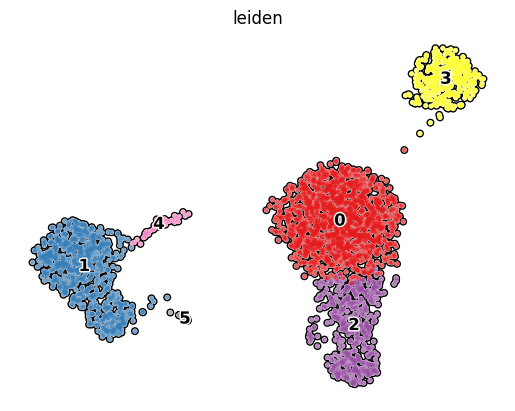

In [4]:
# UMAP 시각화
sc.pl.umap(
    adata,
    color="leiden",  # 클러스터링 결과에 따라 색상 지정
    add_outline=True,  # 클러스터 경계 추가
    legend_loc="on data",  # 범례 위치 설정
    legend_fontsize=12,  # 범례 글꼴 크기 설정
    legend_fontoutline=2,  # 범례 글꼴 외곽선 굵기 설정
    frameon=False,  # 테두리 제거
    palette="Set1",  # 색상 팔레트 설정
)

이 데이터셋은 이미 많이 알려진 것이라. 클러스터에 대한 마커 유전자를 찾고 어떤 세포인지 알아내는 과정은 생략하겠습니다. 

아래와 같이 수동으로 이름을 지정해줍니다. 숫자로 표시되는 각각의 클러스터에 대하여 아래 코드를 통해 이름을 붙여줍니다.


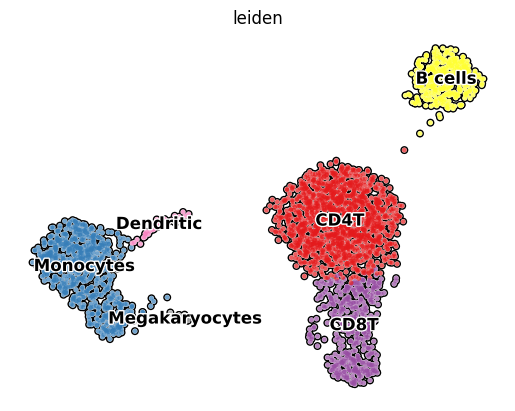

In [5]:
new_cluster_names = [
    "CD4T",  # CD4T 세포
    "Monocytes",  # 단핵구
    "CD8T",  # CD8T 세포
    "B cells",  # B 세포
    "Dendritic",  # 수상돌기세포
    "Megakaryocytes",  # 거대혈소판세포
]
adata.rename_categories("leiden", new_cluster_names)

# 클러스터링된 세포의 UMAP 다시 시각화
sc.pl.umap(
    adata,
    color="leiden",  # 클러스터링 결과에 따라 색상 지정
    add_outline=True,  # 클러스터 경계 추가
    legend_loc="on data",  # 범례 위치 설정
    legend_fontsize=12,  # 범례 글꼴 크기 설정
    legend_fontoutline=2,  # 범례 글꼴 외곽선 굵기 설정
    frameon=False,  # 테두리 제거
    palette="Set1",  # 색상 팔레트 설정
)

이후 데이터를 다시 읽어왔을때와 동일한지 확인하기 위해 `adata` 객체에 포함되어 있는 메타데이터의 데이터형을 확인합니다. 

In [6]:
# adata 메타데이터의 데이터 타입
adata.obs.dtypes

n_genes                 int64
n_genes_by_counts       int32
total_counts          float32
total_counts_mt       float32
pct_counts_mt         float32
leiden               category
dtype: object

## H5AD 파일로 저장하기

AnnData 객체를 저장할때는 H5AD(Hierarchical Data Format 5) 파일을 사용합니다. 이 파일 형식은 대용량 데이터셋의 주요 구성 요소(예: 표현형 데이터, 주석, 메타데이터)를 계층적으로 구조화해서  효율적으로 저장하고 처리할 수 있게 해 줍니다.


In [7]:
# 분석 결과를 저장할 파일 경로
output_path = "../output/pbmc3k/"
# `compression='gzip'`는 디스크 공간을 절약하지만 쓰기와 이후의 읽기가 약간 느려집니다.
adata.write(output_path + "pbmc3k.h5ad", compression="gzip")

## H5AD 파일 다시 불러오기

`sc.read_h5ad` 함수는 H5AD 파일 형식을 AnnData 객체로 직접 불러옵니다.

In [8]:
# 저장했던 h5ad파일을 다시 불러옵니다.
adata = sc.read_h5ad(output_path + "pbmc3k.h5ad")
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

데이터를 다시 불러와보니 유전자의 갯수가 1,838개입니다. `highly variable` 유전자가 아닌 원래 유전자 데이터로 되돌리려면 아래와 같이 해줍니다.

In [9]:
# AnnData 객체를 불러온 후 원시 데이터로 변환
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

이제 유전자의 갯수가 13,714개로 돌아왔습니다.

# `AnnData` to `mtx`

`10x format` 으로 저장하는 방법은 아래와 같습니다.

In [10]:
# genes.tsv 로 유전자 정보 저장
df_genes = adata.var.gene_ids.reset_index()
df_genes.set_index("gene_ids").to_csv(
    output_path + "genes.tsv",
    sep="\t",
    index=True,
    header=False,
)

# barcodes.tsv 로 저장
pd.DataFrame(adata.obs.index).to_csv(
    output_path + "barcodes.tsv",
    sep="\t",
    index=False,
    header=False,
)
# UMAP 좌표 저장
pd.DataFrame(adata.obsm["X_umap"], index=adata.obs_names).to_csv(
    output_path + "UMAP.tsv",
    sep="\t",
    index=True,
    header=True,
)
# 메타 데이터 저장
adata.obs.to_csv(
    output_path + "metadata.tsv",
    sep="\t",
    index=True,
)
# mtx 희소 행렬 저장, Transpose 필요
scipy.io.mmwrite(output_path + "matrix.mtx", adata.X.T)

`output_path`에 파일이 5개 생겼을 것입니다. 

# 다시 `mtx` to `AnnData`

다시 `10x format` 데이터를 읽어서 `AnnData`객체를 만들어 봅니다. 2가지 방법으로 해보겠습니다. 첫번째는 기존에 `read_10x_mtx()`함수를 사용하는 방법이고 두번째는 수작업으로 각각의 데이터를 합치는 방법입니다.

## `read_10x_mtx()`함수 사용

만약 다른 분석 도구를 통해 처리된 데이터의 경우라면 그리 추천하지는 않는 방법입니다.

In [11]:
# 데이터 읽기
adata = sc.read_10x_mtx(
    output_path,  # `.mtx` 파일이 있는 디렉토리
    var_names="gene_symbols",  # 변수 이름에 유전자 기호 사용 (변수 축 인덱스)
)

# `sc.read_10x_mtx`에서 `var_names='gene_ids'`를 사용하는 경우 이 작업이 필요하지 않음
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    var: 'gene_ids'

`adata.var` 출력을 확인해 정상적으로 유전자 이름을 불러왔는지도 확인합니다.

In [12]:
adata.var

,gene_ids
AL627309.1,ENSG00000237683
AP006222.2,ENSG00000228463
RP11-206L10.2,ENSG00000228327
RP11-206L10.9,ENSG00000237491
LINC00115,ENSG00000225880
...,...
AC145212.1,ENSG00000215750
AL592183.1,ENSG00000220023
AL354822.1,ENSG00000215615
PNRC2-1,ENSG00000215700


기존에 작업한 메타데이터와 UMAP 좌표 정보도 불러옵니다.

In [13]:
# 세포 메타데이터 불러오기
cell_meta = pd.read_csv(output_path + "metadata.tsv", sep="\t", index_col=0)
# AnnData 객체에 메타데이터 및 변수 이름 설정
adata.obs = cell_meta

# UMAP 데이터 불러오기
umap = pd.read_csv(
    output_path + "UMAP.tsv",
    sep="\t",
    index_col=0,
)
# UMAP 데이터 설정
adata.obsm["X_umap"] = umap.loc[adata.obs.index].values
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids'
    obsm: 'X_umap'

위 결과를 통해 정상적으로 데이터를 불러왔음을 확인 할 수 있습니다.

## `read_10x_mtx`가 아닌 수작업을 통한 방법

수작업을 통해 만드는 방법을 해봅니다. `10x format`과 동일하지는 않지만 유사한 형태의 경우에는 이 방법이 유용합니다.

In [14]:
# mtx 희소 행렬 불러오기
X = mmread(output_path + "matrix.mtx")

# AnnData 객체 생성
adata = anndata.AnnData(X=X.transpose().tocsr())

# 세포 메타데이터 불러오기
cell_meta = pd.read_csv(output_path + "metadata.tsv", sep="\t", index_col=0)

# 유전자 이름 불러오기
gene_names = pd.read_csv(
    output_path + "genes.tsv",
    sep="\t",
    index_col=None,
    header=None,
    names=["gene_ids", "gene_symbols"],
)

# 바코드 불러오기
barcodes = pd.read_csv(
    input_path + "barcodes.tsv",
    sep="\t",
    index_col=0,
    header=None,
)

# AnnData 객체에 메타데이터 및 변수 이름 설정
adata.obs = cell_meta
adata.obs.index = list(barcodes.index)
adata.var.index = gene_names["gene_symbols"].values
adata.var["gene_ids"] = gene_names["gene_ids"].values

# UMAP 데이터 불러오기
umap = pd.read_csv(
    output_path + "UMAP.tsv",
    sep="\t",
    index_col=0,
)
# UMAP 데이터 설정
adata.obsm["X_umap"] = umap.loc[adata.obs.index].values

# adata 데이터 확인
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids'
    obsm: 'X_umap'

### 메타 데이터의 데이터형 확인하기

위의 방법을 통해 메타 데이터를 불러오면 데이터의 형이 잘못 지정되는 경우가 있습니다.

In [15]:
# adata.obs의 데이터 타입 확인
adata.obs.dtypes

n_genes                int64
n_genes_by_counts      int64
total_counts         float64
total_counts_mt      float64
pct_counts_mt        float64
leiden                object
dtype: object

예를 들면 `leiden` 클러스터는 기본적으로 숫자로 지정되는데 다시 불러오는 과정 중에 `category`가 아닌 `int`형으로 되는 경우가 있습니다. 이번에는 `object`로 되어 있습니다. 아래와 같이 `category`로 수정해줍니다.   

In [16]:
# adata.obs의 'leiden' 열을 범주형으로 변환한 후 데이터 타입 확인
adata.obs.astype({"leiden": "category"}).dtypes

n_genes                 int64
n_genes_by_counts       int64
total_counts          float64
total_counts_mt       float64
pct_counts_mt         float64
leiden               category
dtype: object

UMAP을 그려서 마지막으로 확인해 봅니다.

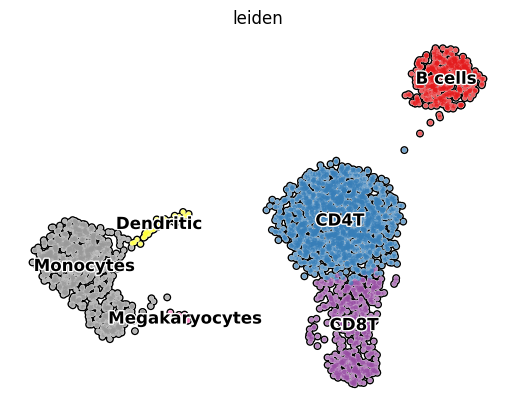

In [17]:
# UMAP 시각화
sc.pl.umap(
    adata,
    color="leiden",  # 클러스터링 결과에 따라 색상 지정
    add_outline=True,  # 클러스터 경계 추가
    legend_loc="on data",  # 범례 위치 설정
    legend_fontsize=12,  # 범례 글꼴 크기 설정
    legend_fontoutline=2,  # 범례 글꼴 외곽선 굵기 설정
    frameon=False,  # 테두리 제거
    palette="Set1",  # 색상 팔레트 설정
)

UMAP이 문제없이 재현되는 것을 확인 할 수 있습니다.

# 나가며

단일세포 RNA 시퀀싱(scRNA-seq) 분야는 빠르게 발전하고 있지만, 여전히 표준화되지 않은 측면이 많습니다. 이는 여러 이유로 설명될 수 있습니다. 그 중에서도 표준화된 프로토콜을 개발하기가 어렵다는 것이 큰 이유라고 생각합니다.

따라서, 현재는 위에서 살펴본 방법처럼 가장 단순한 `mtx`으로 되돌리는 방법을 통해 데이터를 변환하는 것이 최선으로 보여집니다.